In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import shap
import datetime
import numpy as np
import pandas as pd
from pytz import utc
import matplotlib.pyplot as plt
import os

from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files
import oma_tracking.models.mlflow_functions as mlflow_f

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

# Data Paths
data_path = "../../data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = "../../data/nw2/mvbc_data.parquet"
tracked_frequencies_path = "../../data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = "../../data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")

In [4]:
weather_params = \
    [
        'Wave_height', 
        'Sea_water_temperature', 
        'Tide_TAW', 
        'Air_pressure', 
        'Air_temperature', 
        #'Relative_humidity' # TOO MANY NANs
    ]
weather_inputs = mvbc_data[weather_params]

scada_params = \
    [
        'mean_NW2_D01_rpm', 
        'mean_NW2_D01_yaw', 
        'mean_NW2_D01_pitch', 
        'mean_NW2_D01_power', 
        #'std_NW2_D01_towerxacc',  # TOO MANY NANs
        #'std_NW2_D01_toweryacc', # TOO MANY NANs
        #'mean_NW2_D01_towerxacc', # TOO MANY NANs
        #'mean_NW2_D01_toweryacc', # TOO MANY NANs
        'mean_NW2_D01_windspeed',
        'mean_NW2_D01_winddirection',
    ]
scada_inputs = data[scada_params]

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [47]:
from mlflow.tracking import MlflowClient
import mlflow
def get_model_run_id(model_name, stage):
    client = MlflowClient()
    for model_version_info in client.search_model_versions(f"name='{model_name}'"):
        if model_version_info.current_stage == stage:
            return model_version_info.run_id
    raise Exception(f"Could not find a model with name '{model_name}' in stage '{stage}'")

def get_model_flavor(model_name, stage):
    client = MlflowClient()
    for model_version_info in client.search_model_versions(f"name='{model_name}'"):
        if model_version_info.current_stage == stage:
            print(model_version_info)
            return model_version_info.flavors
    raise Exception(f"Could not find a model with name '{model_name}' in stage '{stage}'")

def load_model_by_flavor(model_name, stage):
    """
    Load a model by its name and stage.
    Ensure that the model flavor is the original model flavor.
    (e.g. if the model was saved as a sklearn model,
    it should be loaded as a sklearn model)

    Args:
        model_name (_type_): _description_
        stage (_type_): _description_
    """
    run_id = get_model_run_id(model_name, stage)
    client = MlflowClient()
    model_uri = f"runs:/{run_id}/model"
    model = mlflow.pyfunc.load_model(model_uri=model_uri)
    model_flavor = model.metadata.flavors
    print(model_flavor)
    if 'sklearn' in model_flavor:
        return mlflow.sklearn.load_model(model_uri=model_uri)
    elif 'xgboost' in model_flavor:
        return mlflow.xgboost.load_model(model_uri=model_uri)
    elif 'keras' in model_flavor:
        return mlflow.keras.load_model(model_uri=model_uri)
    elif 'pyfunc' in model_flavor:
        return mlflow.pyfunc.load_model(model_uri=model_uri)
    else:
        raise Exception(f"Could not find a model with name '{model_name}' in stage '{stage}'")

In [55]:
AZURE_STORAGE_ACCESS_KEY = os.getenv('AZURE_STORAGE_ACCESS_KEY')
AZURE_STORAGE_CONNECTION_STRING = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

artifact_root = 'wasbs://test@mlflowstoragev1.blob.core.windows.net'
mlflow_ui_string = mlflow_f.create_mlflow_ui(MLFLOW_TRACKING_URI, artifact_root)
database_url = 'http://127.0.0.1:5000'
mlflow_f.connect_mlflow_ui(mlflow_ui_string, database_url)

experiment_name = 'NW2_scour'
experiment = mlflow_f.run_mlflow_experiment(experiment_name = experiment_name)

Mlflow_tracking_uri passed without checking checking username for ':' and '@' symbols. Manually control the uri!


mlflow experiment set to: NW2_scour


In [64]:
images_path = \
        '/'.join(
            [
                "C:/Users/Max/Documents/OWI_LAB/Code/Packages/oma_tracking/visualizations/",
                "nw2",
                "d01",
                "shap"
            ])

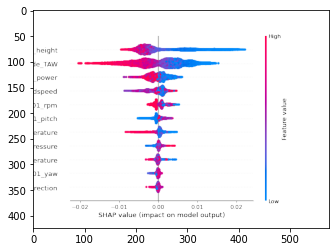

f0da4712ed7d4f8390cca84f4ef939dc


In [66]:
mode = 'SS2'
fig_local_path = images_path + '/' + 'mpe_' + name_location + '_' + mode + '_normalization' +  '_shap_summary_plot.png'
model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
stage = 'Production'
run_id = get_model_run_id(model_name, stage)
import matplotlib.image as mpimg
img = mpimg.imread(fig_local_path)
imgplot = plt.imshow(img)
plt.show()
print(run_id)
with mlflow.start_run(run_id):
    mlflow.log_artifact(
        fig_local_path,
        'figures'
    )
mlflow.end_run()

{'python_function': {'data': 'model.xgb', 'env': 'conda.yaml', 'loader_module': 'mlflow.xgboost', 'python_version': '3.9.12'}, 'xgboost': {'data': 'model.xgb', 'model_class': 'xgboost.sklearn.XGBRegressor', 'xgb_version': '1.6.0'}}


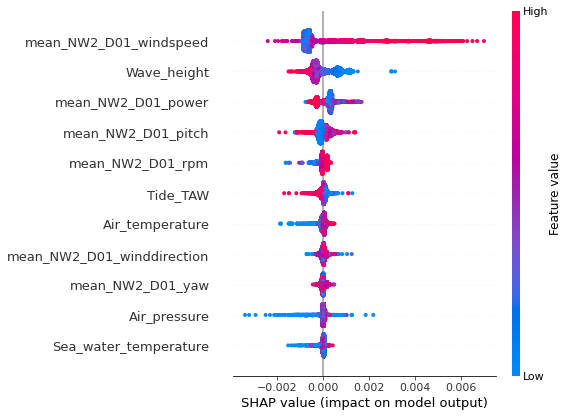

{'python_function': {'env': 'conda.yaml', 'loader_module': 'mlflow.sklearn', 'model_path': 'model.pkl', 'python_version': '3.9.12'}, 'sklearn': {'pickled_model': 'model.pkl', 'serialization_format': 'cloudpickle', 'sklearn_version': '1.2.1'}}


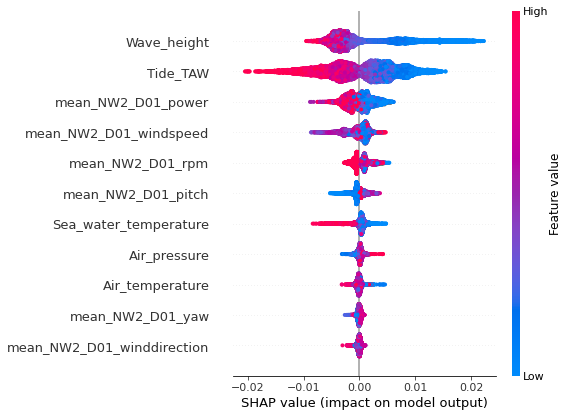

{'python_function': {'env': 'conda.yaml', 'loader_module': 'mlflow.sklearn', 'model_path': 'model.pkl', 'python_version': '3.9.12'}, 'sklearn': {'pickled_model': 'model.pkl', 'serialization_format': 'cloudpickle', 'sklearn_version': '1.2.1'}}


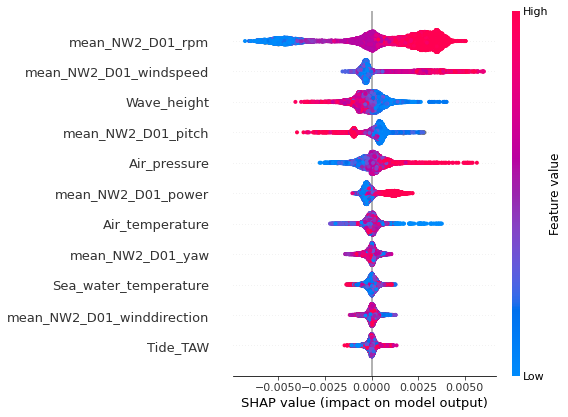

{'python_function': {'env': 'conda.yaml', 'loader_module': 'mlflow.sklearn', 'model_path': 'model.pkl', 'python_version': '3.9.12'}, 'sklearn': {'pickled_model': 'model.pkl', 'serialization_format': 'cloudpickle', 'sklearn_version': '1.2.1'}}


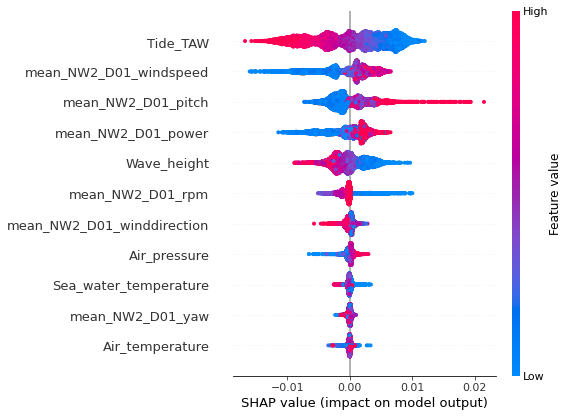

In [73]:
import mlflow

stage = 'Production'
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    images_path = \
        '/'.join(
            [
                "C:/Users/Max/Documents/OWI_LAB/Code/Packages/oma_tracking/visualizations/",
                "nw2",
                "d01",
                "shap"
            ])

    model = load_model_by_flavor(model_name, stage)
    explainer = shap.TreeExplainer(model)
    shap_value = explainer.shap_values(inputs)

    fig_local_path = images_path + '/' + 'mpe_' + name_location + '_' + mode + '_normalization' +  '_shap_summary_plot.png'
    shap.summary_plot(shap_value, inputs, show=False)

    plt.gcf().axes[-1].set_aspect('auto')
    plt.tight_layout()
    plt.gcf().axes[-1].set_box_aspect(50)
    fig = plt.gcf()
    fig.savefig(fig_local_path)
    plt.show()
    plt.close()

    run_id = get_model_run_id(model_name, stage)


    with mlflow.start_run(run_id):
        mlflow.log_artifact(
            fig_local_path,
            'figures'
        )
        mlflow.end_run()

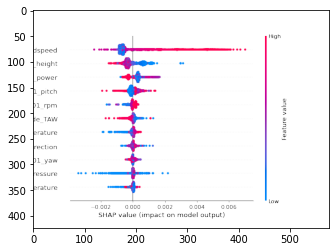

In [21]:
import matplotlib.image as mpimg
img = mpimg.imread(fig_local_path)
imgplot = plt.imshow(img)
plt.show()

In [6]:
import mlflow
models = {}
rund_ids = {}
stage = 'Production'
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    rund_ids[mode] = get_model_run_id(model_name, stage)
    try:
        models[mode] = \
            mlflow.sklearn.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print(stage + ' model ' + model_name + ' not sklearn' )
        try:
            models[mode] = \
                mlflow.xgboost.load_model(
                    model_uri=f"models:/{model_name}/{stage}")
        except:
            print(stage + ' model ' + model_name + ' not xgboost' )
            try:
                models[mode] = \
                    mlflow.pyfunc.load_model(
                        model_uri=f"models:/{model_name}/{stage}")
            except:
                print('no ' + stage + ' model ' + model_name)

Production model mpe_NW2_D01_SS1_normalization not sklearn


SS1


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


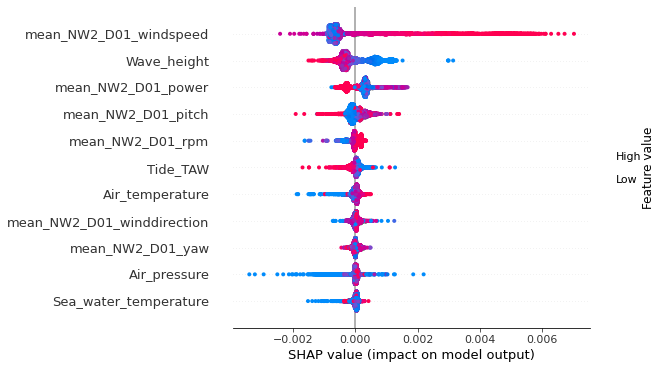

0bc02385673d4e1db6df576751993a65
figure_uploaded


<Figure size 432x288 with 0 Axes>

In [8]:
explainers = {}
shap_values = {}
images_path = \
    '/'.join(
        [
            "C:/Users/Max/Documents/OWI_LAB/Code/Packages/oma_tracking/visualizations/",
            "nw2",
            "d01",
            "shap"
        ])
for mode in tracked_frequencies.columns:
    print(mode)
    model = models[mode]
    explainers[mode] = shap.Explainer(model)
    shap_values[mode] = explainers[mode](inputs)
    shap_summary_plot = shap.summary_plot(shap_values[mode], inputs)
    fig_local_path = images_path + '/' + 'mpe_' + name_location + '_' + mode + '_normalization' +  '_shap_summary_plot.png'
    plt.savefig(fig_local_path)
    run_id = rund_ids[mode]
    print(run_id)
    with mlflow.start_run(run_id):
        mlflow.log_artifacts(
            fig_local_path,
            'figures')
    mlflow.end_run()
    print('figure_uploaded')

In [7]:
explainers = {}
shap_values = {}

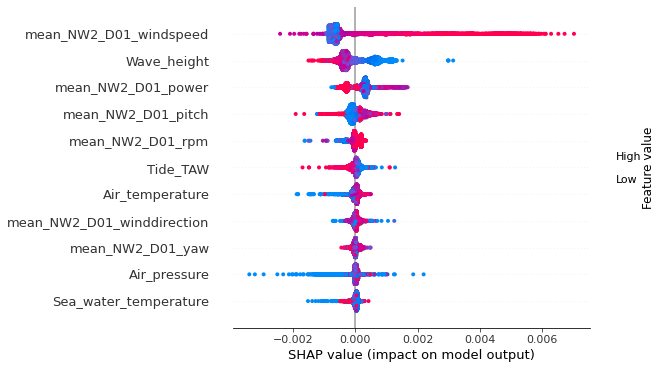

In [12]:
mode = 'SS1'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap_summary_plot = shap.summary_plot(shap_values[mode], inputs)

In [20]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
import oma_tracking.models.mlflow_functions as mlflow_f

from dotenv import load_dotenv
load_dotenv()

True

In [21]:
AZURE_STORAGE_ACCESS_KEY = os.getenv('AZURE_STORAGE_ACCESS_KEY')
AZURE_STORAGE_CONNECTION_STRING = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

artifact_root = 'wasbs://test@mlflowstoragev1.blob.core.windows.net'
mlflow_ui_string = mlflow_f.create_mlflow_ui(MLFLOW_TRACKING_URI, artifact_root)
database_url = 'http://127.0.0.1:5000'
mlflow_f.connect_mlflow_ui(mlflow_ui_string, database_url)

experiment_name = 'NW2_scour'
experiment = mlflow_f.run_mlflow_experiment(experiment_name = experiment_name)

Mlflow_tracking_uri passed without checking checking username for ':' and '@' symbols. Manually control the uri!


mlflow experiment set to: NW2_scour


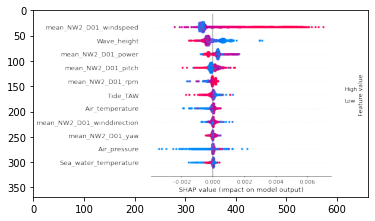

In [37]:
import matplotlib.image as mpimg
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

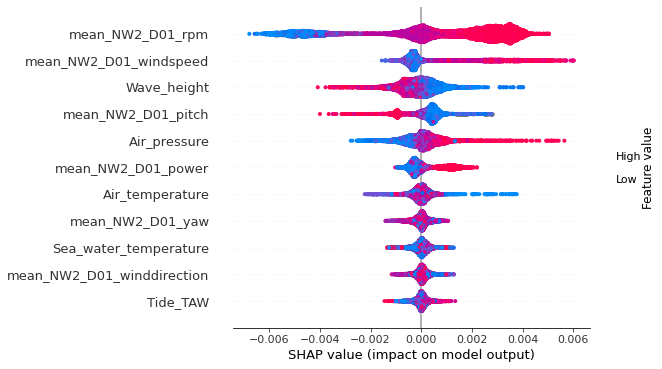

In [8]:
mode = 'FA1'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

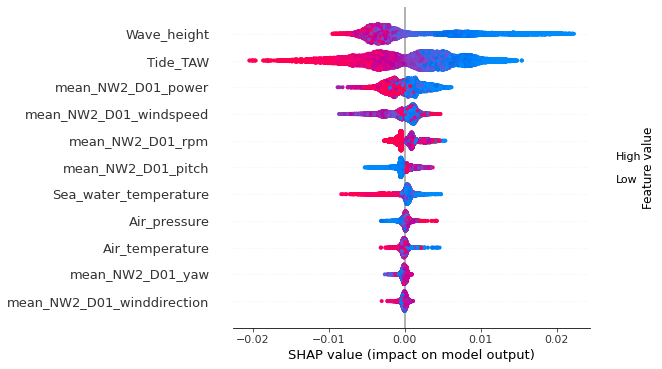

In [9]:
mode = 'SS2'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

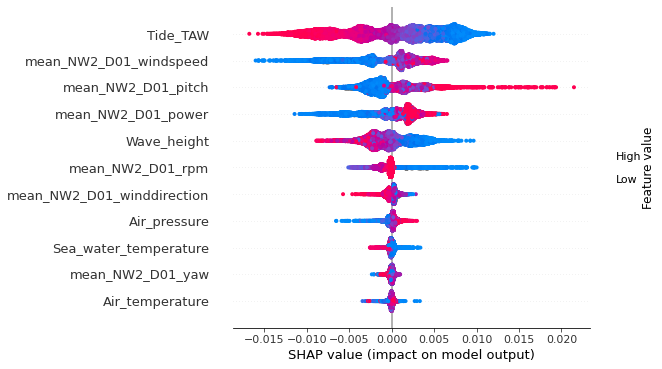

In [10]:
mode = 'FA2'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

SS1


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


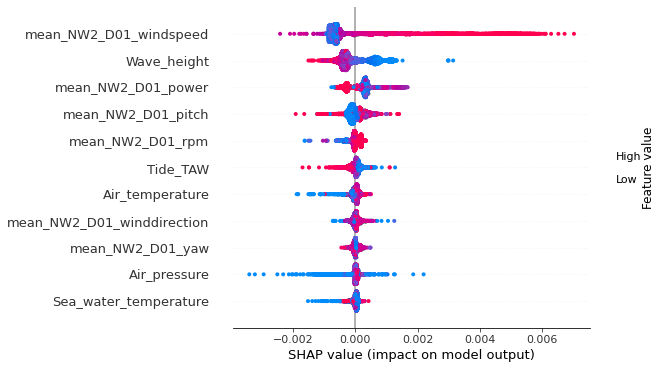